In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import json
from datetime import datetime
from pandas.tseries.offsets import MonthEnd

PERIOD = 'ME'
analyze_start_date = '2014-01-01'
trades = 1

In [2]:
# utility functions to load and save data

def save_to_json(adj_close, volume, data_file):
    """
    Saves adjusted close prices and volume data to a JSON file.

    Parameters:
        adj_close (DataFrame): Adjusted close prices DataFrame.
        volume (DataFrame): Volume data DataFrame.
        data_file (str): Path to the JSON file to save the data.
    """
    try:
        # Convert DataFrames to dictionaries with strings for keys
        adj_close_dict = adj_close.to_dict(orient='index')
        volume_dict = volume.to_dict(orient='index')

        # Ensure keys are strings by converting indexes to strings
        adj_close_dict = {str(key): value for key, value in adj_close_dict.items()}
        volume_dict = {str(key): value for key, value in volume_dict.items()}

        # Structure the data in a single dictionary
        data = {
            "Adj Close": adj_close_dict,
            "Volume": volume_dict
        }

        # Write data to JSON file
        with open(data_file, 'w') as f:
            json.dump(data, f, indent=4)

        print(f"Data successfully saved to {data_file}")
    except Exception as e:
        print(f"An error occurred while saving data: {e}")

def remove_last_month(data_file):
    """
    Removes the last month of data from the JSON file.

    Parameters:
        data_file (str): Path to the JSON file to modify.
    """
    if not os.path.exists(data_file):
        print("JSON file does not exist.")
        return

    try:
        with open(data_file, 'r') as f:
            data = json.load(f)

        # Convert keys back to DataFrames
        adj_close_df = pd.DataFrame(data['Adj Close']).T
        volume_df = pd.DataFrame(data['Volume']).T

        # Remove the last month of data
        adj_close_df.index = pd.to_datetime(adj_close_df.index)
        volume_df.index = pd.to_datetime(volume_df.index)

        last_month = adj_close_df.index.max().strftime('%Y-%m')
        adj_close_df = adj_close_df[~adj_close_df.index.strftime('%Y-%m').str.contains(last_month)]
        volume_df = volume_df[~volume_df.index.strftime('%Y-%m').str.contains(last_month)]

        # Save updated data back to JSON
        save_to_json(adj_close_df, volume_df, data_file)

        print(f"Last month ({last_month}) data removed from {data_file}.")
    except Exception as e:
        print(f"An error occurred while removing the last month: {e}")

def fetch_yfinance_data(start_date, tickers, data_file):
    """
    Checks if the JSON file exists and updates it with missing months of data.
    If doesn't exist then loads it

    Parameters:
        start_date: eg. '2010-01-01'
        tickers (list or str): Tickers to fetch data for.
        data_file (str): Path to the JSON file to check and update.
    """
    current_month = datetime.now().strftime('%Y-%m')

    adj_close = None
    volume = None

    if os.path.exists(data_file):
        with open(data_file, 'r') as f:
            data = json.load(f)

        last_dates = list(data['Adj Close'].keys())
        last_date = max(last_dates)  # Get the most recent date as a string (e.g., '2024-12-14')
        
        # Extract the year and month from the last date
        last_year_month = last_date[:7]  # Format: 'YYYY-MM'
        
        # Extract the year and month from the current date
        current_year_month = datetime.now().strftime('%Y-%m')  # Format: 'YYYY-MM'
        
        # Check if the last year and month are the same as the current year and month
        if last_year_month == current_year_month:
            print("The data is already up-to-date.")
            adj_close = pd.DataFrame(data['Adj Close']).T
            volume = pd.DataFrame(data['Volume']).T

            adj_close.index = pd.to_datetime(adj_close.index)
            volume.index = pd.to_datetime(volume.index)

            return adj_close, volume

        # Load missing months of data
        start_date = f"{last_month}-01"

        print('loading data since', start_date)
        new_data = yf.download(tickers, start=start_date)
        adj_close = new_data['Adj Close']
        volume = new_data['Volume']

        # Drop missing data
        adj_close = adj_close.dropna(axis=1)
        volume = volume.dropna(axis=1)

        # Merge new data with existing data
        adj_close_df = pd.DataFrame(data['Adj Close']).T
        volume_df = pd.DataFrame(data['Volume']).T

        adj_close_df.index = pd.to_datetime(adj_close_df.index)
        volume_df.index = pd.to_datetime(volume_df.index)

        updated_adj_close = pd.concat([adj_close_df, adj_close]).reset_index().drop_duplicates(subset='index').set_index('index')
        updated_volume = pd.concat([volume_df, volume]).reset_index().drop_duplicates(subset='index').set_index('index')

        # Save updated data using save_to_json
        save_to_json(updated_adj_close, updated_volume, data_file)
    else:
        print("JSON file not found. Fetching data from scratch.")
        new_data = yf.download(tickers, start=start_date)
        adj_close = new_data['Adj Close']
        volume = new_data['Volume']

        # Drop missing data
        adj_close = adj_close.dropna(axis=1)
        volume = volume.dropna(axis=1)

        # Save data using save_to_json
        save_to_json(adj_close, volume, data_file)

    return adj_close, volume


In [3]:
start_date = '2010-01-01'
data_file = 'yfinance.json'
# Ticker setup
ticker_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
tickers = ticker_df.Symbol.to_list()

print(f"Fetching data starting from {start_date}...")
df, dv = fetch_yfinance_data(start_date, tickers, data_file)

# Compute monthly returns
mtl = (df.pct_change() + 1)[1:].resample(PERIOD).prod()
cumulative_monthly_volume = dv.resample(PERIOD).sum()  # Monthly cumulative volume
# Compute monthly percentage change for volume
dv_resampled = dv.resample(PERIOD).sum()
mtl_volume = dv_resampled.pct_change().dropna()

Fetching data starting from 2010-01-01...
The data is already up-to-date.


In [4]:
mtl.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,SBUX,SMCI,SNPS,TMUS,TTWO,TXN,VRSK,VRTX,WBD,XEL
2010-01-31 00:00:00+00:00,0.897435,0.870855,0.851279,0.952370,0.926763,0.991700,0.851749,0.769072,1.013167,0.936594,...,0.945336,1.075521,0.947861,0.706399,0.892308,0.869486,0.942044,0.867993,0.956774,0.985768
2010-02-28 00:00:00+00:00,1.065396,1.072755,1.084570,1.020103,1.171921,0.982245,1.009773,1.060322,0.968023,0.944103,...,1.051400,1.211461,1.029619,1.095915,1.036638,1.083556,1.006401,1.055729,1.050236,1.001444
2010-03-31 00:00:00+00:00,1.148470,1.020779,0.992336,1.077119,1.053802,1.016657,1.100490,1.171934,1.057057,1.146706,...,1.059363,1.151233,1.021461,1.147488,1.025988,1.003691,0.996467,1.008140,1.084751,1.030484
2010-04-30 00:00:00+00:00,1.111022,0.949958,1.038515,0.975264,1.156910,1.003511,1.023014,0.978425,0.957721,1.009796,...,1.074891,0.820602,1.012964,1.077684,1.099291,1.067762,0.993617,0.948618,1.146197,1.025944
2010-05-31 00:00:00+00:00,0.983875,0.954762,0.982144,0.942587,0.860841,0.943655,0.942779,0.944873,0.903507,0.915098,...,0.996536,0.969676,0.945278,1.178244,1.066359,0.938870,1.079586,0.892185,0.972373,0.942068


In [5]:
#remove_last_month(data_file)

In [6]:
# stats variables
longs = {}
wins = positions = totalGain = totalLoss = yearGain = maxGain = maxLoss = 0
maxDate = minDate = currentYear = ''
current_symbols = []

mtl_filtered = mtl.loc[analyze_start_date:]

# Loop through all dates in the dataset
for date in mtl_filtered.index:
    try:
        if PERIOD == 'ME':
            # Dynamically extract the preceding 12, 6, and 3 months excluding the current month
            mtl_12 = mtl.loc[date - pd.DateOffset(months=12):date - MonthEnd(1)]
            mtl_6 = mtl.loc[date - pd.DateOffset(months=6):date - MonthEnd(1)]
            mtl_3 = mtl.loc[date - pd.DateOffset(months=3):date - MonthEnd(1)]
        else:
            # Dynamically extract the preceding 12, 6, and 3 weeks excluding the current week
            mtl_12 = mtl.loc[date - pd.DateOffset(weeks=12):date - pd.offsets.Week(weekday=6)]
            mtl_6 = mtl.loc[date - pd.DateOffset(weeks=6):date - pd.offsets.Week(weekday=6)]
            mtl_3 = mtl.loc[date - pd.DateOffset(weeks=3):date - pd.offsets.Week(weekday=6)]

        # Skip if there isn't enough data for any of the windows
        if len(mtl_12) < 12 or len(mtl_6) < 6 or len(mtl_3) < 3:
            print('Not enough data in windows for date:', date)
            continue

        # Calculate rolling products for the specific windows
        ret_12 = mtl_12.apply(np.prod)
        ret_6 = mtl_6.apply(np.prod)
        ret_3 = mtl_3.apply(np.prod)
              
        # Select top symbols for the current date
        top_50 = ret_12.nlargest(50).index.tolist()
        top_30 = ret_6.nlargest(25).index.tolist()
        top_10 = ret_3.nlargest(10).index.tolist()

        # Filter `ret_3` to include only symbols in `cascading_symbols`
        filtered_top_3 = ret_3[top_10]        
        # Sort the filtered symbols by their values in descending order
        sorted_symbols = filtered_top_3.sort_values(ascending=False).index.tolist()

        cascading_symbols = set(top_50).intersection(top_30).intersection(top_10)

        if not cascading_symbols:
            print('No cascading symbols for date:', date)
            continue

        # Get portfolio data and volume for cascading symbols
        cascading_symbols = list(cascading_symbols)  # Ensure it is a list
        # reduce symbols to top 3 performers over past 3 months

        cascading_symbols = [symbol for symbol in sorted_symbols[:trades] if symbol in cascading_symbols]
        portfolio = mtl_filtered.loc[date:, cascading_symbols].values
        portfolio = np.round(portfolio, 2)
        volumes = mtl_volume.loc[date:, cascading_symbols].values
        volumes = np.round(volumes, 2)
        
        if portfolio.size == 0 or portfolio.shape[1] == 0:
            current_symbols = []
            print('No portfolio for date:', date)
            print('')

        else:
            # Calculate the month's cumulative change for the symbols
            yields = portfolio[0:1, :] - 1
            yields = np.round(yields, 2)
    
            volumes = volumes[0:1, :] - 1
            volumes = np.round(volumes, 2)
    
            mean = yields.mean(axis=1)[0] if portfolio.size > 0 else 0
    
            if portfolio.any():
                dateStr = str(date)[:10]
                longs[dateStr] = {'symbols': cascading_symbols, 'total': round(mean, 2), 'returns': yields.tolist(), 'volumes': volumes.tolist()}
                current_symbols = cascading_symbols
                
                totalGain += mean
                yearGain += mean
                
            for p in yields[0]:
                if p > 0:
                    wins += 1
                    if p > maxGain:
                        maxGain = p
                        maxDate = str(date)
                else:
                    totalLoss += p
                    if p < maxLoss:
                        maxLoss = p
                        minDate = str(date)
    
                positions += 1
    
            if dateStr[:4] != currentYear:
                if currentYear:
                    print(currentYear, 'total', round(yearGain,2))
                    print('_______________________________________________________________________')
                    yearGain= 0
    
                currentYear = dateStr[:4]
    
            print(str(date)[:10], longs[dateStr])
            print('______________________________')
    
            if str(date)[:10] == str(mtl_filtered.index[-2])[:10]:
                if currentYear:
                    print(currentYear, 'total', round(yearGain,2))
                    print('_______________________________________________________________________')
                    yearGain= 0

        if str(date)[:10] == str(mtl_filtered.index[-1])[:10]:
            print('*** current symbols:', current_symbols)

    except Exception as e:
        print(f"No data for {date}: {e}")
        continue

# Summary statistics
print('______________________________________')
print('total gain:', round(totalGain,2))
print('positions:', positions, 'wins:', wins, 'loss:', positions-wins, 'win%', round(wins / positions * 100, 2),
      'avg+', round(totalGain / wins , 2) if wins > 0 else 0,
      'avg-', round(totalLoss / (positions - wins) , 2) if positions - wins > 0 else 0)
print('max gain', round(maxGain, 2), 'on', maxDate[:10], 'max loss:', round(maxLoss, 2), 'on', minDate[:10])

2014-01-31 {'symbols': ['ILMN'], 'total': 0.37, 'returns': [[0.37]], 'volumes': [[0.11]]}
______________________________
2014-02-28 {'symbols': ['ILMN'], 'total': 0.13, 'returns': [[0.13]], 'volumes': [[-1.33]]}
______________________________
2014-03-31 {'symbols': ['ILMN'], 'total': -0.13, 'returns': [[-0.13]], 'volumes': [[-0.58]]}
______________________________
2014-04-30 {'symbols': ['ILMN'], 'total': -0.09, 'returns': [[-0.09]], 'volumes': [[-0.95]]}
______________________________
2014-05-31 {'symbols': ['AZN'], 'total': -0.09, 'returns': [[-0.09]], 'volumes': [[-0.2]]}
______________________________
2014-06-30 {'symbols': ['EA'], 'total': 0.02, 'returns': [[0.02]], 'volumes': [[-1.38]]}
______________________________
2014-07-31 {'symbols': ['SMCI'], 'total': 0.04, 'returns': [[0.04]], 'volumes': [[-1.21]]}
______________________________
No portfolio for date: 2014-08-31 00:00:00+00:00

No portfolio for date: 2014-09-30 00:00:00+00:00

2014-10-31 {'symbols': ['MNST'], 'total': 0.1

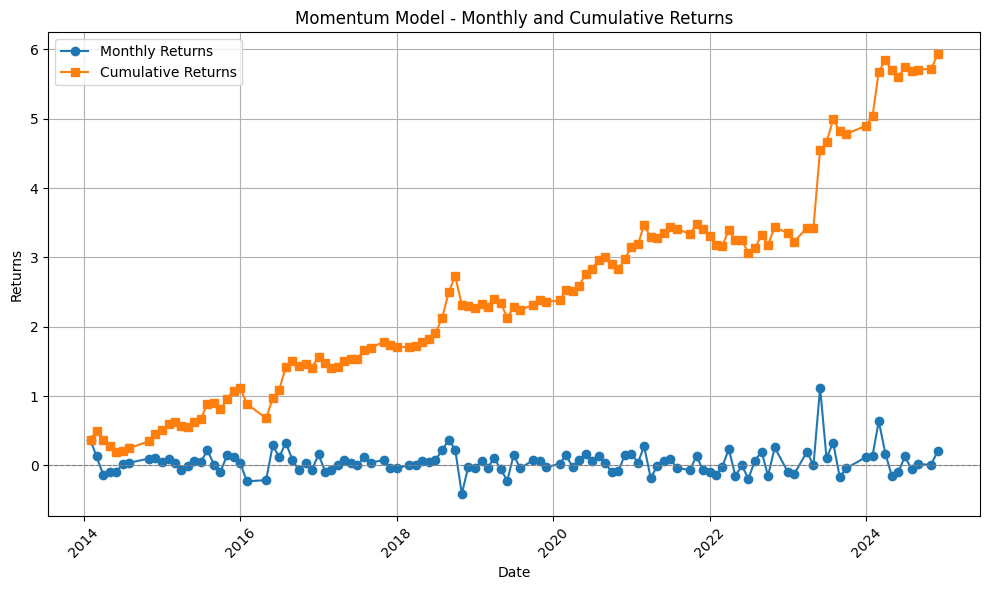

In [7]:
import matplotlib.pyplot as plt

# Dictionary data
data = longs

# Prepare data for plotting
dates = pd.to_datetime(list(data.keys()))
returns = [data[date]['total'] for date in data]

# Calculate cumulative returns
cumulative_returns = pd.Series(returns, index=dates).cumsum()

# Plotting
plt.figure(figsize=(10, 6))

# Monthly returns plot
plt.plot(dates, returns, marker='o', label='Monthly Returns')

# Cumulative returns plot
plt.plot(dates, cumulative_returns, marker='s', label='Cumulative Returns')

# Formatting the chart
plt.title('Momentum Model - Monthly and Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


In [8]:
# Download NASDAQ data
nas_df = yf.download('^IXIC', start='2012-01-01')

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_333613/996259049.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_changes = nas_df.groupby('Month', group_keys=False).apply(


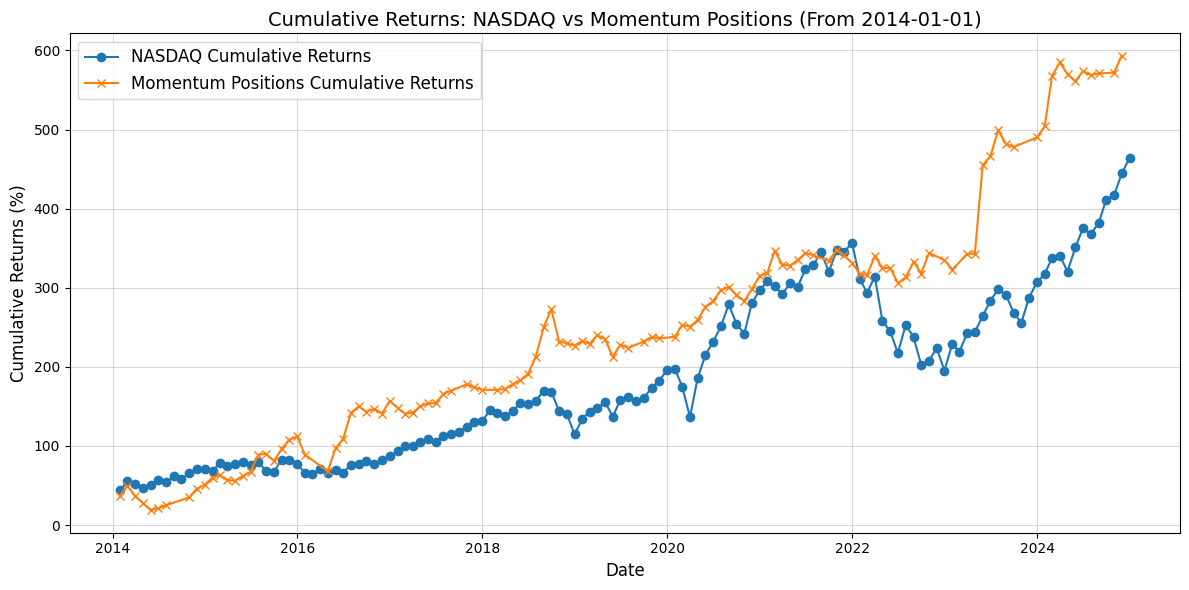

In [9]:
# Download NASDAQ data
nas_df = yf.download('^IXIC', start='2012-01-01')

# Ensure the 'Adj Close' column exists for calculations
if 'Adj Close' in nas_df.columns:
    # Add a 'Month' column to group by
    nas_df['Month'] = nas_df.index.to_period('M')
    
    # Calculate monthly percentage changes
    monthly_changes = nas_df.groupby('Month', group_keys=False).apply(
        lambda x: ((x['Adj Close'].iloc[-1] - x['Adj Close'].iloc[0]) / x['Adj Close'].iloc[0]) * 100
    ).reset_index(name='% Change')
    
    # Convert Month to end-of-month timestamp
    monthly_changes['Month'] = monthly_changes['Month'].dt.to_timestamp('M')
    monthly_changes.set_index('Month', inplace=True)
    
    # Calculate cumulative change
    monthly_changes['Cumulative Change'] = (1 + monthly_changes['% Change'] / 100).cumprod() - 1
    monthly_changes['Cumulative Change'] *= 100  # Convert to percentages

    # Prepare data for long positions
    dates = pd.to_datetime(list(longs.keys()))
    returns = [longs[date.strftime('%Y-%m-%d')]['total'] for date in dates]
    long_cumulative_returns = pd.Series(returns, index=dates).cumsum() * 100  # Scale to percentages

    # Filter data from the start date
    analyze_start_date = pd.to_datetime(analyze_start_date)
    nasdaq_filtered = monthly_changes[monthly_changes.index >= analyze_start_date]
    longs_filtered = long_cumulative_returns[long_cumulative_returns.index >= analyze_start_date]

    # Plot both cumulative returns
    plt.figure(figsize=(12, 6))

    # Plot NASDAQ cumulative returns
    plt.plot(nasdaq_filtered.index, nasdaq_filtered['Cumulative Change'], label='NASDAQ Cumulative Returns', marker='o')

    # Plot long positions cumulative returns
    plt.plot(longs_filtered.index, longs_filtered, label='Momentum Positions Cumulative Returns', marker='x')

    # Add titles and labels
    plt.title(f'Cumulative Returns: NASDAQ vs Momentum Positions (From {analyze_start_date.date()})', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

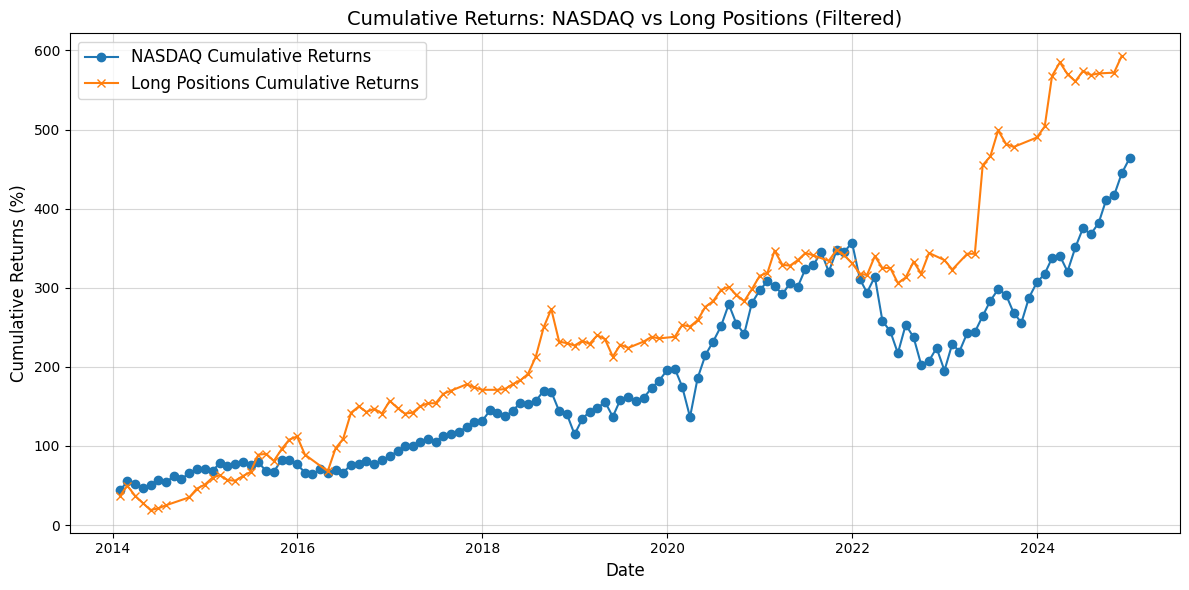

In [10]:
# Prepare data for long positions
dates = pd.to_datetime(list(longs.keys()))
returns = [longs[date.strftime('%Y-%m-%d')]['total'] for date in dates]
long_cumulative_returns = pd.Series(returns, index=dates).cumsum() * 100  # Scale to percentages

# Filter data from the start date
analyze_start_date = pd.to_datetime(analyze_start_date)
nasdaq_filtered = monthly_changes[monthly_changes.index >= analyze_start_date]
longs_filtered = long_cumulative_returns[long_cumulative_returns.index >= analyze_start_date]

# Plot both cumulative returns
plt.figure(figsize=(12, 6))

# Plot NASDAQ cumulative returns
plt.plot(nasdaq_filtered.index, nasdaq_filtered['Cumulative Change'], label='NASDAQ Cumulative Returns', marker='o')

# Plot long positions cumulative returns
plt.plot(longs_filtered.index, longs_filtered, label='Long Positions Cumulative Returns', marker='x')

# Add titles and labels
plt.title('Cumulative Returns: NASDAQ vs Long Positions (Filtered)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()
